Lemon Quality Detection

In [6]:
pip install tensorflow


java_home: unrecognized option `-jdk-23.jdk'
  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.0-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp313-cp313-macosx_11_0_universal2.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.

In [8]:
pip install matplotlib

java_home: unrecognized option `-jdk-23.jdk'
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.1 MB/s eta 0:00:003.4 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.3 MB/s eta 0:00:003.3 MB/s eta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib] 5/6 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [10]:
image_size = 300
batch_size = 32

In [38]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed = 123,
    shuffle = True,
    batch_size = batch_size,
    image_size = (image_size,image_size)
)

Found 2528 files belonging to 3 classes.


In [39]:
class_names=dataset.class_names

In [40]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 300, 300, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 0, 2], dtype=int32)>>


In [41]:
len(dataset)

79

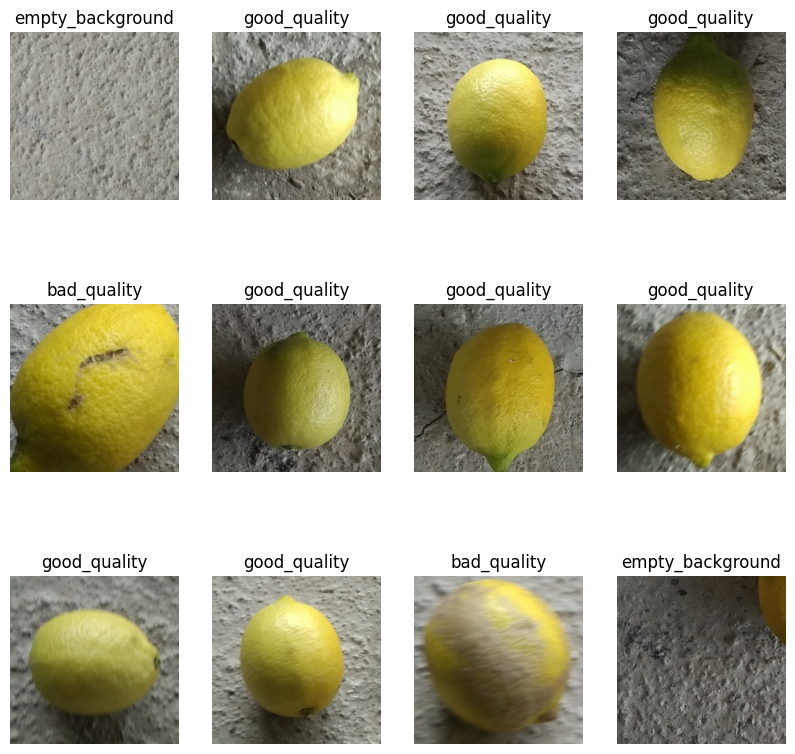

In [42]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [43]:
# split the dataset into train test validation

In [44]:
len(dataset)

79

In [45]:
#training=79*0.8

In [28]:
len(dataset.take(63))

63

In [52]:
def split_dataset(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle =True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size*train_split)
    test_size = int(ds_size*test_split)
    val_size = int(ds_size*val_split)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size).take(test_size)

    return train_ds,test_ds,val_ds

In [53]:
train_ds , test_ds , val_ds = split_dataset(dataset)

In [54]:
len(train_ds)

63

In [55]:
len(test_ds)

7

In [56]:
len(val_ds)

7

In [57]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [58]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [64]:

from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1./299),
])

In [67]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [68]:
train_ds = train_ds.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [73]:
n_classes=3
channel=3

In [74]:
input_shape = (batch_size, image_size ,image_size,channel)

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3),activation = "relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
])

/Users/soumya/Desktop/lemon/myenv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model.build(input_shape=input_shape)

In [78]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 300, 300, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 298, 298, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 149, 149, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 147, 147, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 73, 73, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 71, 71, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 35, 35, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 33, 33, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 14, 14, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 7, 7, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 5, 5, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,387 (501.51 KB)

 Trainable params: 128,387 (501.51 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
    
)

In [83]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 682ms/step - accuracy: 0.6111 - loss: 0.6914 - val_accuracy: 0.8304 - val_loss: 0.3918
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.8031 - loss: 0.4151 - val_accuracy: 0.8482 - val_loss: 0.3454
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 758ms/step - accuracy: 0.8656 - loss: 0.3029 - val_accuracy: 0.8795 - val_loss: 0.2702
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 750ms/step - accuracy: 0.9291 - loss: 0.1835 - val_accuracy: 0.9554 - val_loss: 0.1163
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 690ms/step - accuracy: 0.9514 - loss: 0.1110 - val_accuracy: 0.9464 - val_loss: 0.1497
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 674ms/step - accuracy: 0.9563 - loss: 0.1079 - val_accuracy: 0.9107 - val_loss: 0.1867
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 692ms/step - accuracy: 0.9678 - loss: 0.0899 - val_accuracy: 0.9688 - val_loss: 0.0567
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 678ms/step - accuracy: 0.9688 - loss: 0.0853 - val_accu

In [84]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9777 - loss: 0.0639


In [89]:
epochs=30

In [90]:
history

In [91]:
history.history

{'accuracy': [0.6111111044883728,
  0.80307537317276,
  0.86557537317276,
  0.9290674328804016,
  0.9513888955116272,
  0.9563491940498352,
  0.9677579402923584,
  0.96875,
  0.971230149269104,
  0.9444444179534912,
  0.9747023582458496,
  0.9732142686843872,
  0.985615074634552,
  0.9766865372657776,
  0.9771825671195984,
  0.9747023582458496,
  0.9756944179534912,
  0.9618055820465088,
  0.966269850730896,
  0.9747023582458496,
  0.9771825671195984,
  0.9796627163887024,
  0.9786706566810608,
  0.9846230149269104,
  0.9841269850730896,
  0.9771825671195984,
  0.9846230149269104,
  0.9801587462425232,
  0.9861111044883728,
  0.9826388955116272],
 'loss': [0.691430926322937,
  0.41506651043891907,
  0.3029083013534546,
  0.18351960182189941,
  0.11101225018501282,
  0.10791086405515671,
  0.08989748358726501,
  0.08532687276601791,
  0.08850152790546417,
  0.16423843801021576,
  0.06832144409418106,
  0.06924275308847427,
  0.04606109485030174,
  0.057497505098581314,
  0.0553442575037

In [92]:
history.history.keys

<function dict.keys()>

In [95]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss= history.history["val_loss"]

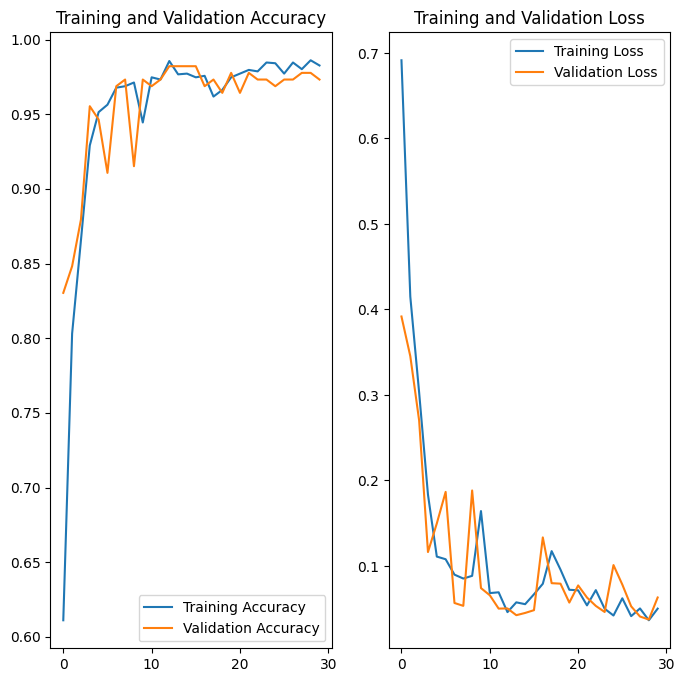

In [96]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [97]:
import numpy as np

first image to predict
actual label good_quality
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
predicted label  good_quality


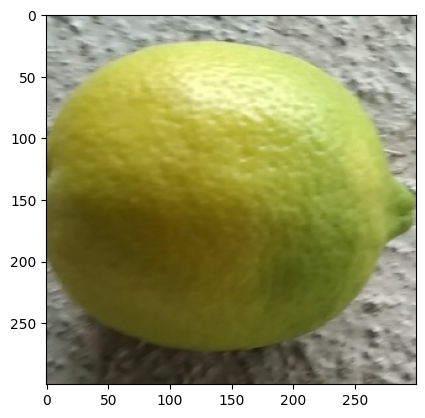

In [103]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[2].numpy().astype("uint8")
    first_label=labels_batch[2].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label ",class_names[np.argmax(batch_prediction[2])])

In [106]:
model.save("lemon.h5")